In [ ]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [6]:
!pip install tqdm

In [7]:
# 🔁 Step 1: Setup and Imports

import os
import cv2
import numpy as np
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt


In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Set working directory inside your Drive (optional)
WORK_DIR = "/content/drive/MyDrive/tbut_dataset"
os.makedirs(WORK_DIR, exist_ok=True)
os.chdir(WORK_DIR)

Mounted at /content/drive


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Path to your labeled frames in Drive
DATA_DIR = "/content/drive/MyDrive/tbut_dataset"

# Image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Class names
class_names = dataset.classes
print("✅ Found classes:", class_names)


✅ Found classes: ['blink', 'good', 'tbut']


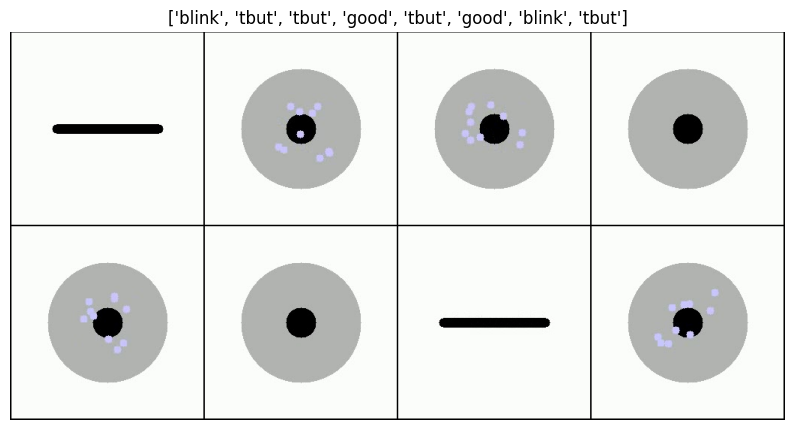

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Helper function to show images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # CHW -> HWC
    mean = np.array([0.0, 0.0, 0.0])  # Assuming no normalization
    std = np.array([1.0, 1.0, 1.0])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# Get one batch
inputs, labels = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

# Display
plt.figure(figsize=(10, 10))
imshow(out, title=[class_names[label] for label in labels])
plt.show()


In [11]:
import torch
print("GPU available? 🔥", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name() if torch.cuda.is_available() else "CPU only")


GPU available? 🔥 True
Device: Tesla T4


In [12]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze early layers (optional for faster training on small dataset)
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer for 3-class classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

print("✅ Model ready on", device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model ready on cuda


In [13]:
from tqdm.notebook import tqdm
import torch

# Training settings
EPOCHS = 10  # You can increase this later
model.train()

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"🔁 Epoch {epoch+1}/{EPOCHS}", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    print(f"✅ Epoch {epoch+1}: Loss = {running_loss:.4f}, Accuracy = {100 * correct / total:.2f}%")


🔁 Epoch 1/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 1: Loss = 4.3461, Accuracy = 26.67%


🔁 Epoch 2/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 2: Loss = 2.8536, Accuracy = 73.33%


🔁 Epoch 3/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 3: Loss = 2.1134, Accuracy = 80.00%


🔁 Epoch 4/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 4: Loss = 1.6480, Accuracy = 86.67%


🔁 Epoch 5/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 5: Loss = 1.5787, Accuracy = 90.00%


🔁 Epoch 6/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 6: Loss = 0.9075, Accuracy = 100.00%


🔁 Epoch 7/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 7: Loss = 0.5482, Accuracy = 100.00%


🔁 Epoch 8/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 8: Loss = 0.6174, Accuracy = 100.00%


🔁 Epoch 9/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 9: Loss = 0.7728, Accuracy = 100.00%


🔁 Epoch 10/10:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Epoch 10: Loss = 0.4458, Accuracy = 100.00%


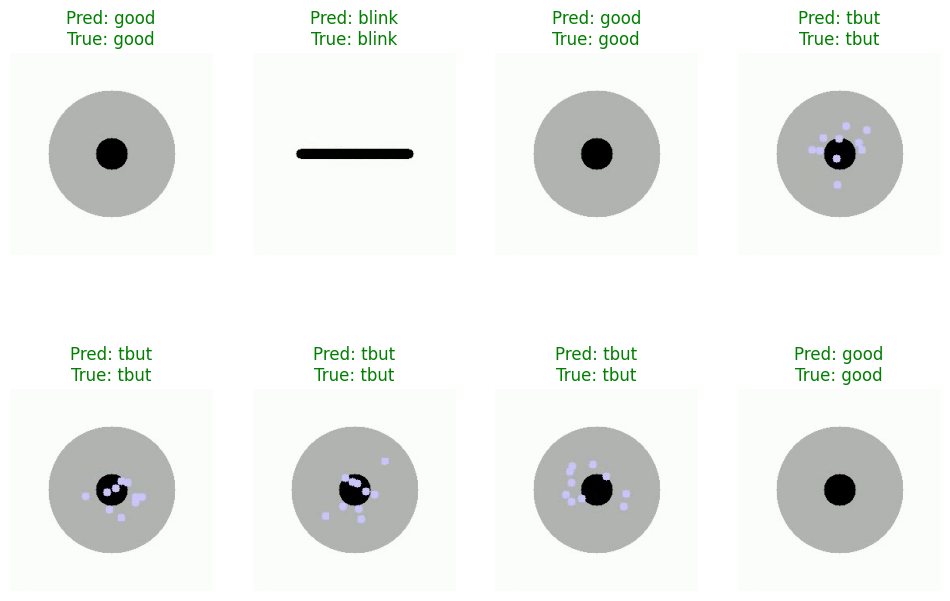

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Put model in eval mode
model.eval()

# Get a batch of images
dataiter = iter(dataloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Visualize results
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')

# Show predictions
fig = plt.figure(figsize=(12, 8))
for idx in range(min(8, images.size(0))):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}",
                 color=("green" if preds[idx]==labels[idx] else "red"))


In [17]:
# Save to a temporary file in Colab's local filesystem
MODEL_LOCAL_PATH = "tbut_resnet18.pth"
torch.save(model.state_dict(), MODEL_LOCAL_PATH)

print(f"✅ Model saved locally as {MODEL_LOCAL_PATH}")


✅ Model saved locally as tbut_resnet18.pth


In [18]:
from google.colab import files
files.download(MODEL_LOCAL_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>